In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import cv2
from PIL import Image
import tensorflow as tf

# Paths
BASE_DIR = 'data'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')
SAVE_DIR = 'saved_models'
os.makedirs(SAVE_DIR, exist_ok=True)

# Parameters
IMG_SIZE = (48, 48)
BATCH_SIZE = 64
NUM_CLASSES = 7
EPOCHS = 50
SEED = 42

labels = ['angry','disgust','fear','happy','sad','surprise','neutral']


In [23]:
BASE_DIR = r'C:\Users\ssanj\emotion-recognition\data'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')

print("TRAIN_DIR exists?", os.path.exists(TRAIN_DIR))
print("TEST_DIR exists?", os.path.exists(TEST_DIR))
print("Train subfolders:", os.listdir(TRAIN_DIR))
import os
print("Current working directory:", os.getcwd())


TRAIN_DIR exists? True
TEST_DIR exists? True
Train subfolders: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Current working directory: C:\Users\ssanj\emotion-recognition


In [27]:
# Train & Validation generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=SEED
)

val_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=SEED
)

# Class weights for imbalanced data
classes = train_generator.classes
#class_weights = class_weight.compute_class_weight('balanced', np.unique(classes), classes)
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = train_generator.classes
unique_classes = np.unique(classes)

class_weights = compute_class_weight(
    class_weight='balanced',  # must be keyword
    classes=unique_classes,   # must be keyword
    y=classes                 # must be keyword
)

class_weights_dict = {i: w for i, w in enumerate(class_weights)}

print("Class indices:", train_generator.class_indices)
print("Class weights:", class_weights_dict)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}
print("Class indices:", train_generator.class_indices)
print("Class weights:", class_weights_dict)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Class indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Class weights: {0: 1.0266404434114071, 1: 9.401555464592715, 2: 1.0009587727708533, 3: 0.5684585684585685, 4: 0.826068191627104, 5: 0.8491570541259982, 6: 1.2933160650937552}
Class indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Class weights: {0: 1.0266404434114071, 1: 9.401555464592715, 2: 1.0009587727708533, 3: 0.5684585684585685, 4: 0.826068191627104, 5: 0.8491570541259982, 6: 1.2933160650937552}


In [29]:
def create_cnn(input_shape=(48,48,1), num_classes=7):
    model = models.Sequential()

    # Block 1
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.25))

    # Block 2
    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.25))

    # Block 3
    model.add(layers.Conv2D(256, (3,3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(256, (3,3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.25))

    # Classifier
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# Create model
model = create_cnn((IMG_SIZE[0], IMG_SIZE[1], 1), NUM_CLASSES)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


C:\Users\ssanj\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,329,031 (8.88 MB)

 Trainable params: 2,326,983 (8.88 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [31]:
# Callbacks
checkpoint_path = os.path.join(SAVE_DIR, 'Emotion_Recognition_CNN.h5')
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    class_weight=class_weights_dict,
    callbacks=callbacks
)

# Save final model
model.save(os.path.join(SAVE_DIR, 'Emotion_Recognition_CNN.h5'))


C:\Users\ssanj\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1739 - loss: 2.4306
Epoch 1: val_loss improved from None to 2.13677, saving model to saved_models\Emotion_Recognition_CNN.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 545s 2s/step - accuracy: 0.1879 - loss: 2.2342 - val_accuracy: 0.1036 - val_loss: 2.1368 - learning_rate: 0.0010
Epoch 2/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 981ms/step - accuracy: 0.2189 - loss: 2.0246
Epoch 2: val_loss improved from 2.13677 to 1.80024, saving model to saved_models\Emotion_Recognition_CNN.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 375s 1s/step - accuracy: 0.2333 - loss: 1.9339 - val_accuracy: 0.2876 - val_loss: 1.8002 - learning_rate: 0.0010
Epoch 3/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2849 - loss: 1.8111
Epoch 3: val_loss improved from 1.80024 to 1.77560, saving model to saved_models\Emotion_Recognition_CNN.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 389s 1s/step - accuracy: 0.3062 - loss: 1.7614 - val_accuracy: 0.3459 - val_loss: 1.7756 - learning_rate: 0.0010
Epoch 4/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3716 - loss: 1.6215
Epoch 4: val_loss improved from 1.77560 to 1.59946, saving model to saved_models\Emotion_Recognition_CNN.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 487s 1s/step - accuracy: 0.3827 - loss: 1.5811 - val_accuracy: 0.3994 - val_loss: 1.5995 - learning_rate: 0.0010
Epoch 5/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4018 - loss: 1.5463
Epoch 5: val_loss did not improve from 1.59946
359/359 ━━━━━━━━━━━━━━━━━━━━ 1990s 6s/step - accuracy: 0.4169 - loss: 1.5060 - val_accuracy: 0.3189 - val_loss: 1.7367 - learning_rate: 0.0010
Epoch 6/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 805ms/step - accuracy: 0.4484 - loss: 1.4158
Epoch 6: val_loss improved from 1.59946 to 1.42936, saving model to saved_models\Emotion_Recognition_CNN.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 304s 846ms/step - accuracy: 0.4528 - loss: 1.4218 - val_accuracy: 0.4525 - val_loss: 1.4294 - learning_rate: 0.0010
Epoch 7/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 816ms/step - accuracy: 0.4691 - loss: 1.4019
Epoch 7: val_loss did not improve from 1.42936
359/359 ━━━━━━━━━━━━━━━━━━━━ 310s 864ms/step - accuracy: 0.4728 - loss: 1.3931 - val_accuracy: 0.4565 - val_loss: 1.4423 - learning_rate: 0.0010
Epoch 8/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 812ms/step - accuracy: 0.4883 - loss: 1.3257
Epoch 8: val_loss improved from 1.42936 to 1.34877, saving model to saved_models\Emotion_Recognition_CNN.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 306s 853ms/step - accuracy: 0.4879 - loss: 1.3424 - val_accuracy: 0.4879 - val_loss: 1.3488 - learning_rate: 0.0010
Epoch 9/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 820ms/step - accuracy: 0.5028 - loss: 1.3036
Epoch 9: val_loss improved from 1.34877 to 1.30366, saving model to saved_models\Emotion_Recognition_CNN.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 310s 864ms/step - accuracy: 0.5044 - loss: 1.3021 - val_accuracy: 0.4963 - val_loss: 1.3037 - learning_rate: 0.0010
Epoch 10/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 811ms/step - accuracy: 0.5104 - loss: 1.2874
Epoch 10: val_loss did not improve from 1.30366
359/359 ━━━━━━━━━━━━━━━━━━━━ 306s 853ms/step - accuracy: 0.5099 - loss: 1.2769 - val_accuracy: 0.4905 - val_loss: 1.3146 - learning_rate: 0.0010
Epoch 11/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 785ms/step - accuracy: 0.5214 - loss: 1.2467
Epoch 11: val_loss improved from 1.30366 to 1.28668, saving model to saved_models\Emotion_Recognition_CNN.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 297s 829ms/step - accuracy: 0.5241 - loss: 1.2471 - val_accuracy: 0.5093 - val_loss: 1.2867 - learning_rate: 0.0010
Epoch 12/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 806ms/step - accuracy: 0.5282 - loss: 1.2216
Epoch 12: val_loss improved from 1.28668 to 1.21179, saving model to saved_models\Emotion_Recognition_CNN.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 306s 851ms/step - accuracy: 0.5347 - loss: 1.2198 - val_accuracy: 0.5429 - val_loss: 1.2118 - learning_rate: 0.0010
Epoch 13/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 872ms/step - accuracy: 0.5424 - loss: 1.1983
Epoch 13: val_loss did not improve from 1.21179
359/359 ━━━━━━━━━━━━━━━━━━━━ 331s 922ms/step - accuracy: 0.5435 - loss: 1.1947 - val_accuracy: 0.5229 - val_loss: 1.2532 - learning_rate: 0.0010
Epoch 14/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 868ms/step - accuracy: 0.5506 - loss: 1.1778
Epoch 14: val_loss did not improve from 1.21179
359/359 ━━━━━━━━━━━━━━━━━━━━ 328s 912ms/step - accuracy: 0.5478 - loss: 1.1763 - val_accuracy: 0.5368 - val_loss: 1.2282 - learning_rate: 0.0010
Epoch 15/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 829ms/step - accuracy: 0.5573 - loss: 1.1368
Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 15: val_loss did not improve from 1.21179
359/359 ━━━━━━━━━━━━━━━━━━━━ 314s 873ms/step - accuracy: 0.5573 - loss: 1.14

359/359 ━━━━━━━━━━━━━━━━━━━━ 323s 900ms/step - accuracy: 0.5712 - loss: 1.0969 - val_accuracy: 0.5844 - val_loss: 1.1167 - learning_rate: 5.0000e-04
Epoch 17/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 857ms/step - accuracy: 0.5859 - loss: 1.0635
Epoch 17: val_loss improved from 1.11667 to 1.11571, saving model to saved_models\Emotion_Recognition_CNN.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 325s 904ms/step - accuracy: 0.5882 - loss: 1.0631 - val_accuracy: 0.5748 - val_loss: 1.1157 - learning_rate: 5.0000e-04
Epoch 18/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 842ms/step - accuracy: 0.5951 - loss: 1.0275
Epoch 18: val_loss did not improve from 1.11571
359/359 ━━━━━━━━━━━━━━━━━━━━ 318s 887ms/step - accuracy: 0.5926 - loss: 1.0375 - val_accuracy: 0.5152 - val_loss: 1.3521 - learning_rate: 5.0000e-04
Epoch 19/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 846ms/step - accuracy: 0.5931 - loss: 1.0280
Epoch 19: val_loss improved from 1.11571 to 1.09929, saving model to saved_models\Emotion_Recognition_CNN.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 319s 889ms/step - accuracy: 0.5931 - loss: 1.0332 - val_accuracy: 0.5879 - val_loss: 1.0993 - learning_rate: 5.0000e-04
Epoch 20/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 853ms/step - accuracy: 0.6048 - loss: 1.0167
Epoch 20: val_loss did not improve from 1.09929
359/359 ━━━━━━━━━━━━━━━━━━━━ 322s 898ms/step - accuracy: 0.6017 - loss: 1.0139 - val_accuracy: 0.5874 - val_loss: 1.1003 - learning_rate: 5.0000e-04
Epoch 21/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 825ms/step - accuracy: 0.6041 - loss: 1.0035
Epoch 21: val_loss improved from 1.09929 to 1.05393, saving model to saved_models\Emotion_Recognition_CNN.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 313s 872ms/step - accuracy: 0.6001 - loss: 1.0163 - val_accuracy: 0.5990 - val_loss: 1.0539 - learning_rate: 5.0000e-04
Epoch 22/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 864ms/step - accuracy: 0.6145 - loss: 0.9743
Epoch 22: val_loss did not improve from 1.05393
359/359 ━━━━━━━━━━━━━━━━━━━━ 327s 911ms/step - accuracy: 0.6114 - loss: 0.9906 - val_accuracy: 0.5938 - val_loss: 1.1179 - learning_rate: 5.0000e-04
Epoch 23/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 877ms/step - accuracy: 0.6103 - loss: 0.9878
Epoch 23: val_loss did not improve from 1.05393
359/359 ━━━━━━━━━━━━━━━━━━━━ 331s 921ms/step - accuracy: 0.6070 - loss: 1.0033 - val_accuracy: 0.5637 - val_loss: 1.1671 - learning_rate: 5.0000e-04
Epoch 24/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 854ms/step - accuracy: 0.6043 - loss: 0.9870
Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 24: val_loss did not improve from 1.05393
359/359 ━━━━━━━━━━━━━━━━━━━━ 323s 898ms/step - accuracy: 0.6103 

359/359 ━━━━━━━━━━━━━━━━━━━━ 317s 882ms/step - accuracy: 0.6309 - loss: 0.9207 - val_accuracy: 0.6114 - val_loss: 1.0454 - learning_rate: 2.5000e-04
Epoch 27/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 777ms/step - accuracy: 0.6289 - loss: 0.9100
Epoch 27: val_loss did not improve from 1.04535
359/359 ━━━━━━━━━━━━━━━━━━━━ 294s 818ms/step - accuracy: 0.6324 - loss: 0.9156 - val_accuracy: 0.6046 - val_loss: 1.0775 - learning_rate: 2.5000e-04
Epoch 28/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 786ms/step - accuracy: 0.6333 - loss: 0.9170
Epoch 28: val_loss improved from 1.04535 to 1.02709, saving model to saved_models\Emotion_Recognition_CNN.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 297s 828ms/step - accuracy: 0.6360 - loss: 0.9084 - val_accuracy: 0.6163 - val_loss: 1.0271 - learning_rate: 2.5000e-04
Epoch 29/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 786ms/step - accuracy: 0.6368 - loss: 0.8978
Epoch 29: val_loss improved from 1.02709 to 1.01670, saving model to saved_models\Emotion_Recognition_CNN.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 297s 829ms/step - accuracy: 0.6417 - loss: 0.8917 - val_accuracy: 0.6166 - val_loss: 1.0167 - learning_rate: 2.5000e-04
Epoch 30/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 778ms/step - accuracy: 0.6404 - loss: 0.8908
Epoch 30: val_loss did not improve from 1.01670
359/359 ━━━━━━━━━━━━━━━━━━━━ 294s 820ms/step - accuracy: 0.6409 - loss: 0.8913 - val_accuracy: 0.6124 - val_loss: 1.0356 - learning_rate: 2.5000e-04
Epoch 31/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 794ms/step - accuracy: 0.6434 - loss: 0.8783
Epoch 31: val_loss did not improve from 1.01670
359/359 ━━━━━━━━━━━━━━━━━━━━ 300s 836ms/step - accuracy: 0.6400 - loss: 0.8868 - val_accuracy: 0.6152 - val_loss: 1.0395 - learning_rate: 2.5000e-04
Epoch 32/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 784ms/step - accuracy: 0.6439 - loss: 0.8823
Epoch 32: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 32: val_loss did not improve from 1.01670
359/359 ━━━━━━━━━━━━━━━━━━━━ 297s 827ms/step - accuracy: 0.6462 

359/359 ━━━━━━━━━━━━━━━━━━━━ 297s 827ms/step - accuracy: 0.6477 - loss: 0.8633 - val_accuracy: 0.6198 - val_loss: 1.0119 - learning_rate: 1.2500e-04
Epoch 34/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6584 - loss: 0.8549
Epoch 34: val_loss did not improve from 1.01191
359/359 ━━━━━━━━━━━━━━━━━━━━ 490s 1s/step - accuracy: 0.6568 - loss: 0.8532 - val_accuracy: 0.6243 - val_loss: 1.0187 - learning_rate: 1.2500e-04
Epoch 35/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 768ms/step - accuracy: 0.6574 - loss: 0.8510
Epoch 35: val_loss did not improve from 1.01191
359/359 ━━━━━━━━━━━━━━━━━━━━ 290s 809ms/step - accuracy: 0.6592 - loss: 0.8500 - val_accuracy: 0.6208 - val_loss: 1.0172 - learning_rate: 1.2500e-04
Epoch 36/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6688 - loss: 0.8296
Epoch 36: val_loss improved from 1.01191 to 1.00583, saving model to saved_models\Emotion_Recognition_CNN.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 2231s 6s/step - accuracy: 0.6634 - loss: 0.8393 - val_accuracy: 0.6306 - val_loss: 1.0058 - learning_rate: 1.2500e-04
Epoch 37/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 848ms/step - accuracy: 0.6632 - loss: 0.8296
Epoch 37: val_loss did not improve from 1.00583
359/359 ━━━━━━━━━━━━━━━━━━━━ 319s 888ms/step - accuracy: 0.6611 - loss: 0.8407 - val_accuracy: 0.6267 - val_loss: 1.0280 - learning_rate: 1.2500e-04
Epoch 38/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 795ms/step - accuracy: 0.6694 - loss: 0.8320
Epoch 38: val_loss did not improve from 1.00583
359/359 ━━━━━━━━━━━━━━━━━━━━ 300s 837ms/step - accuracy: 0.6631 - loss: 0.8334 - val_accuracy: 0.6332 - val_loss: 1.0068 - learning_rate: 1.2500e-04
Epoch 39/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 785ms/step - accuracy: 0.6690 - loss: 0.8199
Epoch 39: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 39: val_loss did not improve from 1.00583
359/359 ━━━━━━━━━━━━━━━━━━━━ 297s 827ms/step - accuracy: 0.6633 - l

359/359 ━━━━━━━━━━━━━━━━━━━━ 304s 848ms/step - accuracy: 0.6645 - loss: 0.8205 - val_accuracy: 0.6354 - val_loss: 0.9961 - learning_rate: 6.2500e-05
Epoch 41/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 802ms/step - accuracy: 0.6679 - loss: 0.8132
Epoch 41: val_loss did not improve from 0.99605
359/359 ━━━━━━━━━━━━━━━━━━━━ 304s 846ms/step - accuracy: 0.6681 - loss: 0.8131 - val_accuracy: 0.6267 - val_loss: 1.0012 - learning_rate: 6.2500e-05
Epoch 42/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 809ms/step - accuracy: 0.6690 - loss: 0.8145
Epoch 42: val_loss improved from 0.99605 to 0.98810, saving model to saved_models\Emotion_Recognition_CNN.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 306s 852ms/step - accuracy: 0.6712 - loss: 0.8126 - val_accuracy: 0.6340 - val_loss: 0.9881 - learning_rate: 6.2500e-05
Epoch 43/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6772 - loss: 0.8006
Epoch 43: val_loss did not improve from 0.98810
359/359 ━━━━━━━━━━━━━━━━━━━━ 413s 1s/step - accuracy: 0.6735 - loss: 0.8094 - val_accuracy: 0.6332 - val_loss: 1.0079 - learning_rate: 6.2500e-05
Epoch 44/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 756ms/step - accuracy: 0.6728 - loss: 0.7932
Epoch 44: val_loss did not improve from 0.98810
359/359 ━━━━━━━━━━━━━━━━━━━━ 287s 798ms/step - accuracy: 0.6722 - loss: 0.7970 - val_accuracy: 0.6330 - val_loss: 1.0049 - learning_rate: 6.2500e-05
Epoch 45/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 783ms/step - accuracy: 0.6743 - loss: 0.8015
Epoch 45: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 45: val_loss did not improve from 0.98810
359/359 ━━━━━━━━━━━━━━━━━━━━ 295s 823ms/step - accuracy: 0.6766 - loss

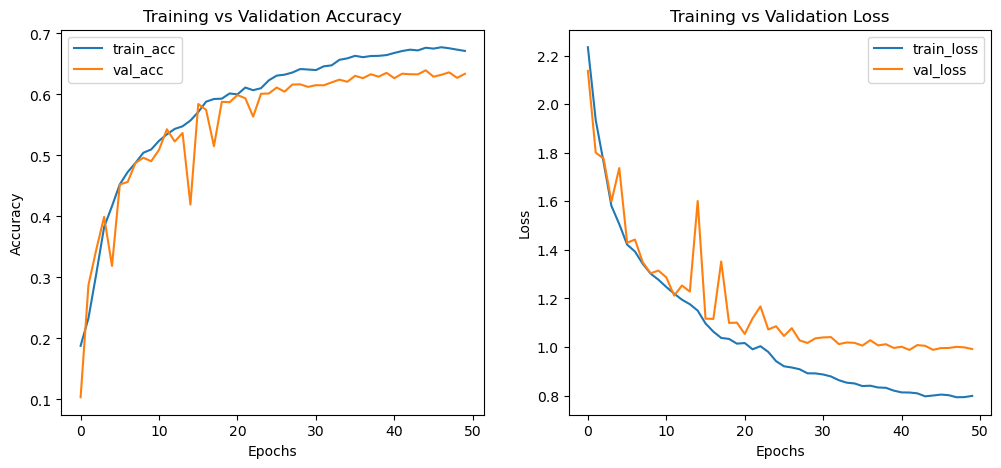

In [33]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')

plt.show()


Found 6504 images belonging to 7 classes.
102/102 ━━━━━━━━━━━━━━━━━━━━ 61s 600ms/step
Classification Report:
              precision    recall  f1-score   support

       angry     0.5518    0.6065    0.5778       958
     disgust     0.6179    0.6847    0.6496       111
        fear     0.5882    0.4004    0.4765      1024
       happy     0.9037    0.8309    0.8658      1774
         sad     0.5325    0.7178    0.6114      1233
    surprise     0.5736    0.4467    0.5023      1247
     neutral     0.3515    0.8217    0.4924       157

    accuracy                         0.6322      6504
   macro avg     0.5885    0.6441    0.5965      6504
weighted avg     0.6503    0.6322    0.6314      6504



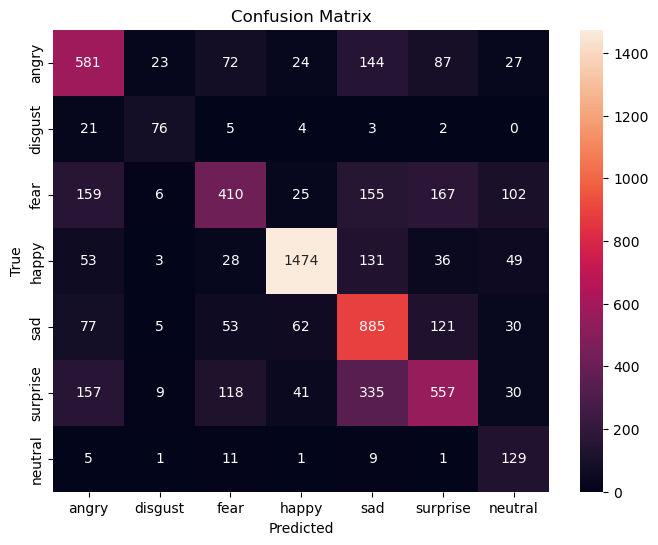

In [35]:
# Test generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Predictions
preds = model.predict(test_generator)
y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels, digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [39]:
def preprocess_img(img_path):
    img = Image.open(img_path).convert('L').resize(IMG_SIZE)
    arr = np.array(img).astype('float32') / 255.0
    arr = arr.reshape((1, IMG_SIZE[0], IMG_SIZE[1], 1))
    return arr

def predict(img_path):
    arr = preprocess_img(img_path)
    preds = model.predict(arr)
    idx = int(np.argmax(preds))
    return labels[idx], float(np.max(preds))

# Example usage
img_path = 'data/test/angry/PrivateTest_1623042.jpg'
label, conf = predict(img_path)
print(f"Predicted: {label} (confidence: {conf:.3f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted: angry (confidence: 0.472)
